[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kadit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kadit\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Enter the subreddit name:  cryptocurrency
Enter the number of keywords to search:  3
Enter keyword 1:  Bitcoin
Enter cryptocurrency symbols separated by commas (e.g., BTC, ETH):  BTC
Enter the start date for Bitcoin (YYYY-MM-DD):  2024-09-15
Enter the end date for Bitcoin (YYYY-MM-DD):  2024-12-11
Enter the file name to save results for Bitcoin:  BTC_SENT


Data saved to 'BTC_SENT.csv'
Average Sentiment Score for Bitcoin: 0.09349999999999999
Sentiment Summary for Bitcoin:
Positive: 43.48%
Neutral: 30.43%
Negative: 26.09%


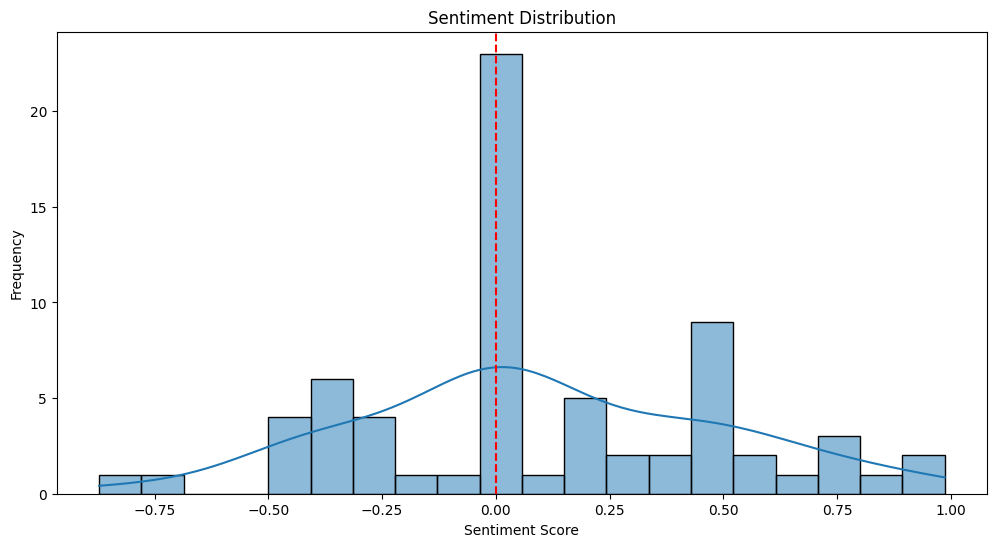

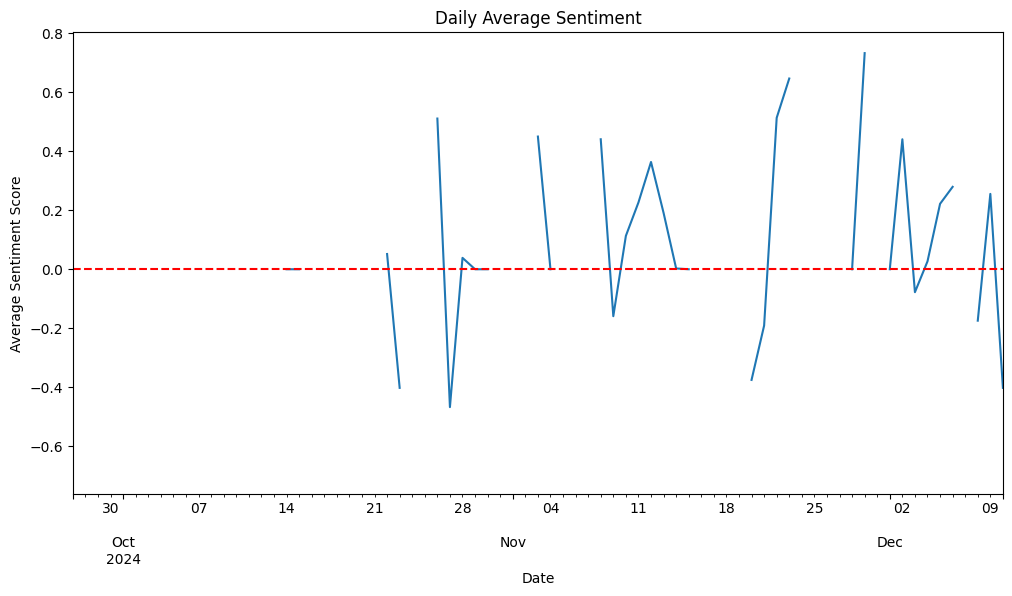

Enter keyword 2:  Solana
Enter cryptocurrency symbols separated by commas (e.g., BTC, ETH):  SOL
Enter the start date for Solana (YYYY-MM-DD):  2024-09-15
Enter the end date for Solana (YYYY-MM-DD):  2024-12-11
Enter the file name to save results for Solana:  SOL_SENT


Data saved to 'SOL_SENT.csv'
Average Sentiment Score for Solana: -0.124448
Sentiment Summary for Solana:
Positive: 28.00%
Neutral: 24.00%
Negative: 48.00%


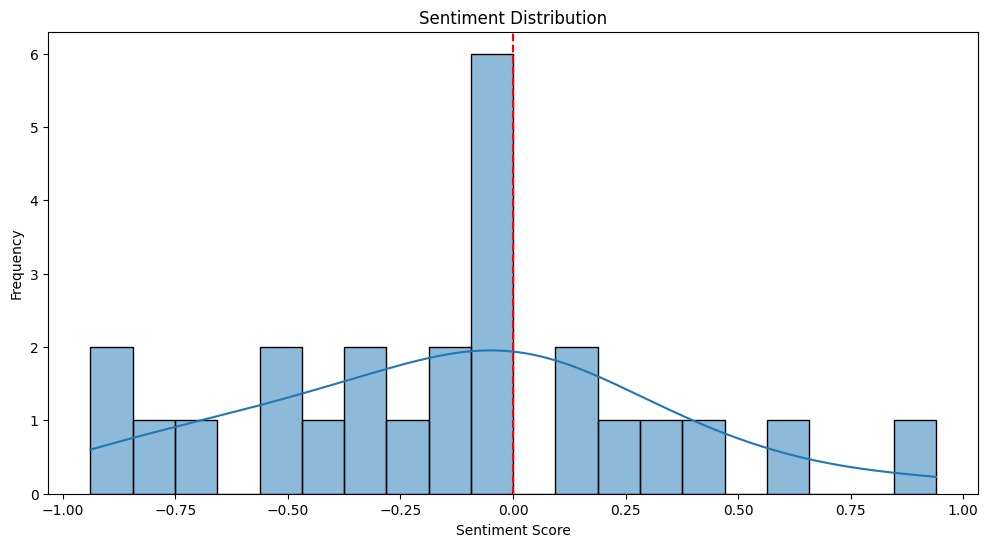

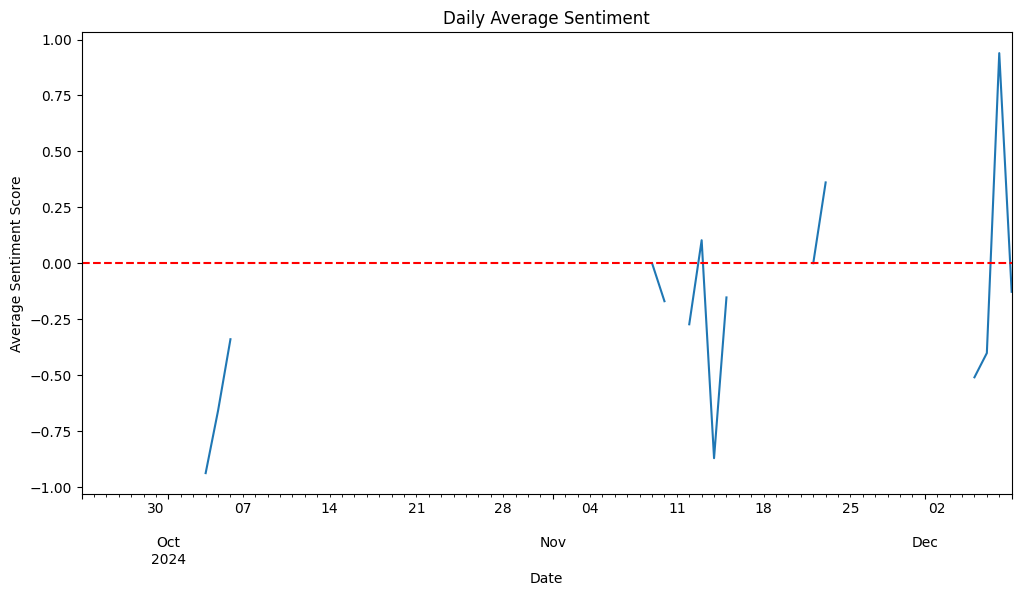

Enter keyword 3:  XRP
Enter cryptocurrency symbols separated by commas (e.g., BTC, ETH):  XRP
Enter the start date for XRP (YYYY-MM-DD):  2024-09-15
Enter the end date for XRP (YYYY-MM-DD):  2024-12-11
Enter the file name to save results for XRP:  XRP_SENT


Data saved to 'XRP_SENT.csv'
Average Sentiment Score for XRP: 0.09487551020408165
Sentiment Summary for XRP:
Positive: 32.65%
Neutral: 55.10%
Negative: 12.24%


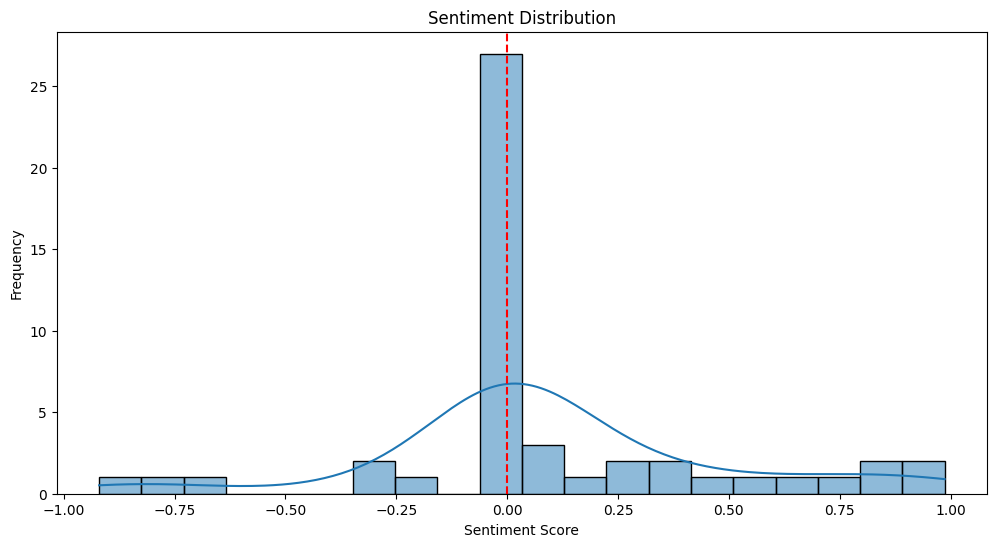

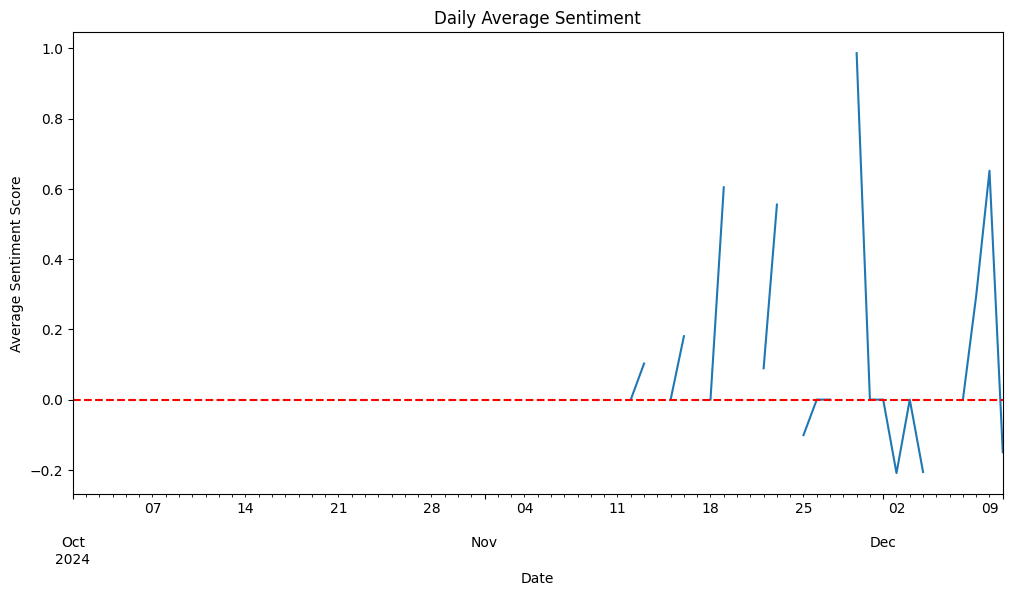

In [12]:
import praw
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer

# Ensure all required NLTK data packages are downloaded
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Set up Reddit API
reddit = praw.Reddit(
    client_id='WjtkxfuXi45EsTdRTKeRvg',
    client_secret='WcHksFYPls-wtCt8kUraMoZq6W4a1Q',
    user_agent='myapp by u/Artistic_Guard_8463',
    username='Artistic_Guard_8463',
    password='Adityashravan@1'
)

# Function to retrieve Reddit posts
def get_reddit_posts(subreddit, keyword, start_date, end_date, num_posts=1000):
    posts = []
    try:
        for submission in reddit.subreddit(subreddit).search(keyword, limit=num_posts):
            submission_date = pd.to_datetime(submission.created_utc, unit='s')
            if start_date <= submission_date <= end_date:
                posts.append({
                    'title': submission.title, 
                    'content': submission.selftext, 
                    'created_utc': submission.created_utc
                })
    except Exception as e:
        print(f"Error fetching posts: {e}")
    return pd.DataFrame(posts)

# Preprocess Text Data
tokenizer = RegexpTokenizer(r'\w+')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Sentiment Analysis Function
def analyze_sentiment(df):
    sia = SentimentIntensityAnalyzer()
    df['sentiment'] = df['clean_text'].apply(lambda text: sia.polarity_scores(text)['compound'])
    
    # Sentiment Classification
    df['sentiment_class'] = df['sentiment'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))
    return df

# Visualization Functions
def plot_sentiment_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['sentiment'], kde=True, bins=20)
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='r', linestyle='--')  # Add line for neutral sentiment
    plt.show()

def plot_sentiment_trends(df):
    df['date'] = pd.to_datetime(df['created_utc'], unit='s')
    df.set_index('date', inplace=True)
    daily_sentiment = df.resample('D')['sentiment'].mean()
    
    plt.figure(figsize=(12, 6))
    daily_sentiment.plot(title='Daily Average Sentiment')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.axhline(y=0, color='r', linestyle='--')  # Neutral line
    plt.show()

# Main Program
def main():
    subreddit = input("Enter the subreddit name: ")
    num_keywords = int(input("Enter the number of keywords to search: "))

    for i in range(num_keywords):
        keyword = input(f"Enter keyword {i+1}: ")
        symbols = input("Enter cryptocurrency symbols separated by commas (e.g., BTC, ETH): ")
        start_date = pd.to_datetime(input(f"Enter the start date for {keyword} (YYYY-MM-DD): "))
        end_date = pd.to_datetime(input(f"Enter the end date for {keyword} (YYYY-MM-DD): "))
        file_name = input(f"Enter the file name to save results for {keyword}: ")

        reddit_posts = get_reddit_posts(subreddit, keyword, start_date, end_date, num_posts=1000)

        if reddit_posts.empty:
            print(f"No posts retrieved for {keyword}.")
            continue

        # Preprocess text and analyze sentiment
        reddit_posts['clean_text'] = (reddit_posts['title'] + ' ' + reddit_posts['content']).apply(preprocess_text)
        reddit_posts = analyze_sentiment(reddit_posts)

        # Add human-readable timestamp
        reddit_posts['timestamp'] = pd.to_datetime(reddit_posts['created_utc'], unit='s')

        # Save results to CSV
        reddit_posts.to_csv(f'{file_name}.csv', index=False)
        print(f"Data saved to '{file_name}.csv'")

        # Display Results
        print(f"Average Sentiment Score for {keyword}:", reddit_posts['sentiment'].mean())
        sentiment_summary = reddit_posts['sentiment_class'].value_counts(normalize=True) * 100
        print(f"Sentiment Summary for {keyword}:")
        print(f"Positive: {sentiment_summary.get('positive', 0):.2f}%")
        print(f"Neutral: {sentiment_summary.get('neutral', 0):.2f}%")
        print(f"Negative: {sentiment_summary.get('negative', 0):.2f}%")

        # Generate visualizations
        plot_sentiment_distribution(reddit_posts)
        plot_sentiment_trends(reddit_posts)

if __name__ == '__main__':
    main()


Rate limit exceeded. Retrying in 60 seconds...
Rate limit exceeded. Retrying in 60 seconds...
Rate limit exceeded. Retrying in 60 seconds...
Rate limit exceeded. Retrying in 60 seconds...
Rate limit exceeded. Retrying in 60 seconds...
Rate limit exceeded. Retrying in 60 seconds...


C:\Python312\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
C:\Users\kadit\AppData\Local\Temp\ipykernel_17920\1929859332.py:32: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dates = [datetime.datetime.utcfromtimestamp(item[0]) for item in coin_data]


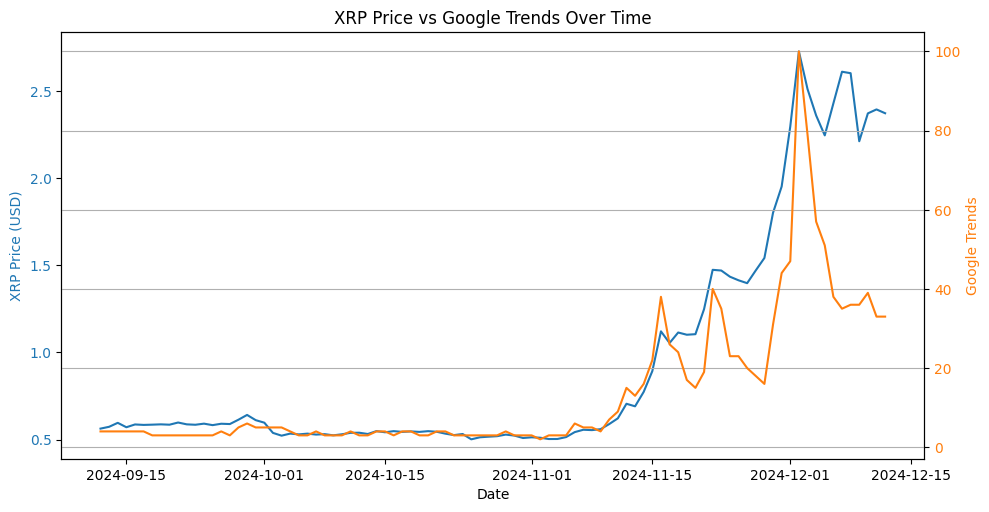

Rate limit exceeded. Retrying in 60 seconds...
Rate limit exceeded. Retrying in 60 seconds...


C:\Python312\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
C:\Users\kadit\AppData\Local\Temp\ipykernel_17920\1929859332.py:32: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dates = [datetime.datetime.utcfromtimestamp(item[0]) for item in coin_data]


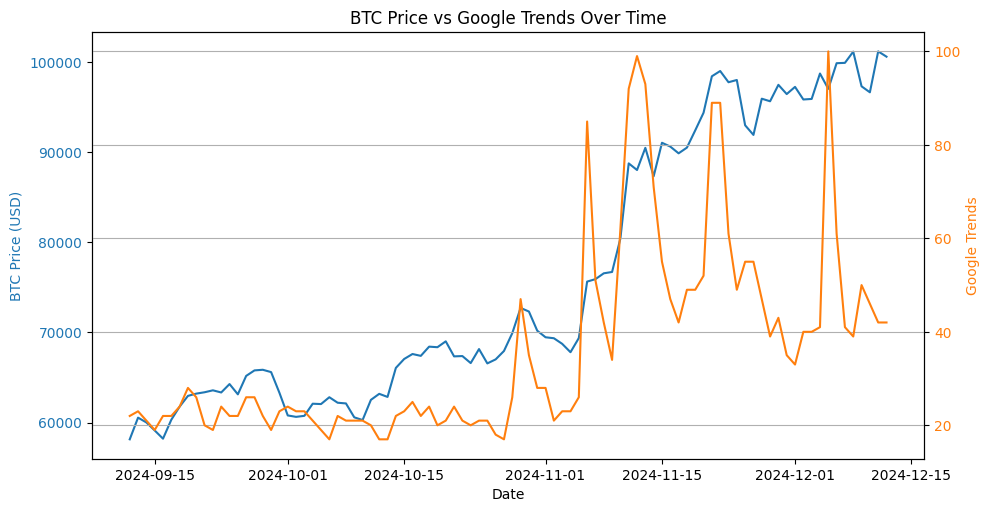

C:\Python312\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
C:\Users\kadit\AppData\Local\Temp\ipykernel_17920\1929859332.py:32: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dates = [datetime.datetime.utcfromtimestamp(item[0]) for item in coin_data]


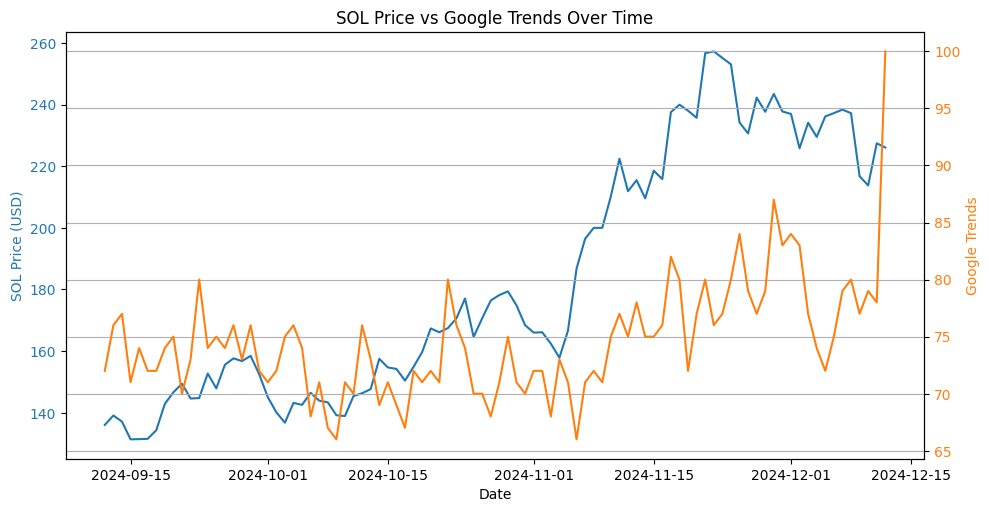

In [7]:
import requests
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from pytrends.request import TrendReq
import time

# Fetch data from Coinbase API for a specific coin
def fetch_coinbase_data(coin):
    url = f"https://api.exchange.coinbase.com/products/{coin}-USD/candles?granularity=86400"
    response = requests.get(url)
    return response.json()

# Fetch Google Trends data with error handling
def fetch_google_trends_data(keyword):
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload([keyword], timeframe='today 3-m')
    
    while True:
        try:
            trends_data = pytrends.interest_over_time()
            return trends_data
        except Exception as e:
            if '429' in str(e):
                print("Rate limit exceeded. Retrying in 60 seconds...")
                time.sleep(60)
            else:
                raise e

# Process and plot the data
def plot_data(coin_data, trends_data, coin_name):
    dates = [datetime.datetime.utcfromtimestamp(item[0]) for item in coin_data]
    prices = [item[4] for item in coin_data]  # Closing price

    trends_data.reset_index(inplace=True)
    trends_data['date'] = pd.to_datetime(trends_data['date'])

    # Merge datasets
    df = pd.DataFrame({'date': dates, 'price': prices})
    merged_data = pd.merge(df, trends_data, left_on='date', right_on='date')

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{coin_name} Price (USD)', color='tab:blue')
    ax1.plot(merged_data['date'], merged_data['price'], label=f"{coin_name} Price (USD)", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Google Trends', color='tab:orange')
    ax2.plot(merged_data['date'], merged_data[coin_name], label="Google Trends", color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    fig.tight_layout()
    plt.title(f"{coin_name} Price vs Google Trends Over Time")
    plt.grid(True)
    plt.show()

# Main function to fetch and plot data for multiple coins
def main():
    coins = ['XRP', 'BTC', 'SOL']
    
    for coin in coins:
        coin_data = fetch_coinbase_data(coin)
        trends_data = fetch_google_trends_data(coin)
        
        plot_data(coin_data, trends_data, coin)

if __name__ == "__main__":
    main()